<a href="https://colab.research.google.com/github/textnorms/date_text_norm/blob/master/T5_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Wed May 27 23:23:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! rm -rf date*
! git clone https://github.com/textnorms/date_text_norm.git
! cp -r date_text_norm/syntetic_data/ .

!pip install -q num2words transformers
! pip install -q transformers

Cloning into 'date_text_norm'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 107 (delta 60), reused 49 (delta 20), pack-reused 0
Receiving objects: 100% (107/107), 44.58 KiB | 549.00 KiB/s, done.
Resolving deltas: 100% (60/60), done.
     |████████████████████████████████| 102kB 5.4MB/s 
     |████████████████████████████████| 665kB 27.4MB/s 
     |████████████████████████████████| 1.1MB 55.5MB/s 
     |████████████████████████████████| 890kB 58.3MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 


In [0]:
# Basics
import numpy as np
import pandas as pd
import random

# Synthetic data generator
from syntetic_data import DateTextGenerator

# PyTorch
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# Matplot lib
import matplotlib.pyplot as plt

### Deterministic experiments

In [0]:
manual_seed = 2357 # only primes, cuz I like
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Deterministic experiment, seed: 2357
Using device: cuda


## Config constants

In [0]:
# Model params
MODEL_SZ = 't5-small'
TOK = T5Tokenizer.from_pretrained(MODEL_SZ)
MAX_LEN_SRC  = 40
MAX_LEN_TRGT = 12

# Train params
BATCH_SZ = 128
N_EPOCHS = 8
WINDOW   = 7

# Dataset

In [0]:
datas = DateTextGenerator(start_date='01/01/1921',
                          end_date='31/12/2020',
                          text_noise_rate=0.1)

examples = datas.generate_demo(date='27/11/1983'); examples.head(63)

,Input Pattern,Generated Text,Origin Sample
0,1,vinte e sete de novembro de 1983,27/11/1983
1,2,"vinte e sete de nov de mil, novecentos e oiten...",27/11/1983
2,3,"vinte e sete de novembro de mil, novecentos e ...",27/11/1983
3,4,"vigésimo sétimo dia do mês onze de mil, novece...",27/11/1983
4,5,27 de Novembro de 1983,27/11/1983
...,...,...,...
58,59,27 / novembro / 1983,27/11/1983
59,60,27/nov/1983,27/11/1983
60,61,27 / nov / 1983,27/11/1983
61,62,27/11/1983,27/11/1983


In [0]:
df = datas.generate_date_dataset(); df

,Input Pattern,Noise Type,Input,Target
0,33,N/A,01-janeiro-1921,01/01/1921
1,36,N/A,02 - jan - 1921,02/01/1921
2,35,N/A,03-jan-1921,03/01/1921
3,7,lookalike_replace_noise,"04-01 de mii, novecentos e vlnte e um",04/01/1921
4,22,N/A,05 do mês um de 1921,05/01/1921
...,...,...,...,...
36520,47,N/A,27.dezembro.2020,27/12/2020
36521,19,N/A,28.12 dois mil e vinte,28/12/2020
36522,51,N/A,29 / 12 / 20,29/12/2020
36523,35,N/A,30-dez-2020,30/12/2020


In [0]:
# Inspectig text generative methods in datasets
df['Input Pattern'].value_counts()/len(df)

33    0.017084
1     0.017084
62    0.016893
57    0.016893
37    0.016756
        ...   
27    0.015113
9     0.015003
14    0.014839
40    0.014483
6     0.013936
Name: Input Pattern, Length: 63, dtype: float64

In [0]:
# Inpsecting noise rate per samples
df['Noise Type'].value_counts()/len(df)

N/A                        0.900698
unexpected_space_noise     0.034661
lookalike_replace_noise    0.032690
remove_char_noise          0.031951
Name: Noise Type, dtype: float64

## Function to split the dataset

In [0]:
def split_data(data, labels, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(
        data,
        labels,
        shuffle=True, 
        test_size=test_size,
        random_state=manual_seed
        )
    return x_train, x_test, y_train, y_test

# creating test set
x_train, x_test, y_train, y_test = split_data(df.Input.values, 
                                              df.Target.values, 
                                              test_size=0.2)

# creating valid set
x_train, x_val, y_train, y_val = split_data(x_train, 
                                            y_train, 
                                            test_size=0.2)

# checking
len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)

(23376, 23376, 5844, 5844, 7305, 7305)

In [0]:
class DateDataset(Dataset):
    def __init__(self, data, label, tokenizer, source_max_length, target_max_length):
        self.tokenizer = tokenizer
        self.data = data
        self.label = label
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        source = self.data[idx]
        target = self.label[idx]

        source_tokenized = self.tokenizer.encode_plus(
            f'{source} {self.tokenizer.eos_token}',
            max_length=self.source_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        target_tokenized = self.tokenizer.encode_plus(
            f'{target} {self.tokenizer.eos_token}',
            max_length=self.target_max_length,
            pad_to_max_length=True,
            return_tensors='pt')

        source_token_ids = source_tokenized['input_ids'].squeeze()
        source_mask = source_tokenized['attention_mask'].squeeze()
        target_token_ids = target_tokenized['input_ids'].squeeze()
        
        return source_token_ids, source_mask, target_token_ids

## Checking the DateDataset class

In [0]:
dataset_debug = DateDataset(
    x_train, 
    y_train,
    TOK,
    MAX_LEN_SRC,
    MAX_LEN_TRGT,
    )

dataloader_checking = DataLoader(
    dataset_debug, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0
    )

source_token_ids, source_mask, target_token_ids = next(iter(dataloader_checking))
print(f'source_token_ids:\n {source_token_ids} --- shape:{source_token_ids.shape}')
print(f'source_mask:\n {source_mask} --- shape:{source_mask.shape}')
print(f'target_token_ids:\n {target_token_ids} --- shape:{target_token_ids.shape}')

source_token_ids:
 tensor([[  103,   776,    20,   150,   162,    51,  5702,    20, 15533,     6,
           150,   162,  3728,    32,     7,     3,    15,  1394,  5277,     9,
             3,    15,   103,   159,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]) --- shape:torch.Size([1, 40])
source_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) --- shape:torch.Size([1, 40])
target_token_ids:
 tensor([[  586, 20223, 13523,  4056,     1,     0,     0,     0,     0,     0,
             0,     0]]) --- shape:torch.Size([1, 12])


## Datasets e Dataloaders

In [0]:
# datasets
ds_debug = DateDataset(x_train[:BATCH_SZ], y_train[:BATCH_SZ], TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_train = DateDataset(x_train, y_train, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_valid = DateDataset(x_val, y_val, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)
ds_test  = DateDataset(x_test, y_test, TOK, MAX_LEN_SRC, MAX_LEN_TRGT)

print('Datasets len:')
print(f'len ds_debug: {len(ds_debug)}')
print(f'len ds_train: {len(ds_train)}')
print(f'len ds_valid: {len(ds_valid)}')
print(f'len ds_test:  {len(ds_test)}')

# dataloaders
dataloaders = {
    'debug': DataLoader(
         ds_debug,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'train': DataLoader(
         ds_train,
         batch_size=BATCH_SZ,
         shuffle=True,
         num_workers=2,
         pin_memory=True),
    'valid': DataLoader(
         ds_valid,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
    'test': DataLoader(
         ds_test,
         batch_size=BATCH_SZ,
         shuffle=False,
         num_workers=2,
         pin_memory=True),
               }
# sanity check
print('\nDataloaders len (in batch):')
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}; dl_sizes

Datasets len:
len ds_debug: 128
len ds_train: 23376
len ds_valid: 5844
len ds_test:  7305

Dataloaders len (in batch):


{'debug': 1, 'test': 58, 'train': 183, 'valid': 46}

In [0]:
# testando o dataloader 
source_token_ids, source_mask, target_token_ids = next(iter(dataloaders['test']))

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_SZ)
    
    def forward(self, token_ids, att_mask, labels):
        outputs = self.model.forward(
            input_ids=token_ids, 
            attention_mask=att_mask,
            lm_labels=labels
            )
        return outputs[0] # loss
    
    @torch.no_grad()    
    def generate(self, token_ids, att_mask, max_len_target):
        predict = self.model.generate(
            input_ids=token_ids, 
            attention_mask=att_mask,
            max_length=max_len_target
            )
        return predict
    
    @torch.no_grad()  
    def generate_example(self, text_input, tokenizer, max_len_source=MAX_LEN_SRC):

        self.model.eval()
        
        example_tokenized = tokenizer.encode_plus(
            f'{text_input} {tokenizer.eos_token}',
            max_length=max_len_source,
            pad_to_max_length=True,
            return_tensors='pt')
            
        example_token_ids = example_tokenized['input_ids']
        example_mask = example_tokenized['attention_mask']

        predicted_example = self.model.generate(
            input_ids=example_token_ids.to(device), 
            attention_mask=example_mask.to(device),
            max_length=MAX_LEN_TRGT
            )

        self.model.train()

        out_text = [tokenizer.decode(text) for text in predicted_example]
        
        return out_text

## Train and evaluation functions

In [0]:
# acc metric for text inputs
def acc_in_text(trues, preds): 
    acc = []
    for d in zip(trues, preds):
        if d[0] == d[1]:
            acc.append(1)
        else:
            acc.append(0)
    return acc # bool

def train(model, device, train_loader, optimizer):
    loss_train = []
    model.train()
    for source_token_ids, source_mask, target_token_ids in train_loader:
        optimizer.zero_grad()
        loss = model(
            source_token_ids.to(device), 
            source_mask.to(device), 
            target_token_ids.to(device)
            )
        
        loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
  
    return sum(loss_train) / len(loss_train)

def evaluate_fn(model, device, val_loader, max_len=MAX_LEN_TRGT):
    all_acc, all_preds, all_trues = [], [], []
    model.eval()
    for source_token_ids, source_mask, target_token_ids in val_loader:
        predicted_ids = model.generate(
            source_token_ids.to(device), 
            source_mask.to(device),
            max_len
            )
        
        preds = [TOK.decode(t) for t in predicted_ids]
        trues = [TOK.decode(t) for t in target_token_ids]
        acc = acc_in_text(trues, preds)
        all_acc.extend(acc)
        all_trues.extend(trues)
        all_preds.extend(preds)
        
    return np.array(all_acc).mean(), all_trues, all_preds

# Overfit in one batch 
- dataloader debug

In [0]:
overfit = False

if overfit:

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    deterministic() 

    model = Net().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    
    # -----------------------------------------------------------------------------
    start.record()
    for step in range(1, 1001):
        samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
        loss_t = train(model, device, dataloaders['debug'], optimizer)
        acc, trues, preds = evaluate_fn(model, device, dataloaders['debug'])
        if step == 1:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
        if step % 100 == 0:
            print(f'[Epoch: {step}/{1000}] |', end=' ')
            print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
            print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')
    end.record()
    torch.cuda.synchronize()    
    # -----------------------------------------------------------------------------

    print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')
    del model

# Training 

In [0]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
deterministic() 

model = Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# ---------------------------------------------------------------------------------
start.record()

for step in range(1, N_EPOCHS+1):
    samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
    loss_t = train(model, device, dataloaders['train'], optimizer)
    acc, trues, preds = evaluate_fn(model, device, dataloaders['valid'])
    print(f'[Epoch: {step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')
    print(f'  Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Training time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 2357



[Epoch: 1/8] | Train Loss: 1.627 -- Acc: 0.396
  Trues: ['28/06/1944', '31/10/1946', '02/08/1959', '27/10/1955', '23/10/2012', '12/10/2008', '02/08/2002']
  Preds: ['28/06/1944', '3/1946', '02.1959', '27/08/1955', '23/10/19 2012', '12/10/2008', '02/11/1920']
[Epoch: 2/8] | Train Loss: 0.365 -- Acc: 0.582
  Trues: ['13/09/1985', '18/05/1936', '11/11/1996', '23/03/2016', '19/01/1979', '25/06/1967', '12/05/1990']
  Preds: ['13/06/1985', '18/05/1936', '11/11/1996', '23/03/1916', '20/01/1979', '25/06/1967', '12/05/1990']
[Epoch: 3/8] | Train Loss: 0.256 -- Acc: 0.686
  Trues: ['01/06/1921', '28/01/2001', '09/08/1991', '16/08/2005', '22/05/1963', '11/08/1972', '18/09/1991']
  Preds: ['01/06/1921', '28/01/2001', '09/08/1991', '16/08/2005', '22/05/1963', '11/08/1982', '18/09/1991']
[Epoch: 4/8] | Train Loss: 0.195 -- Acc: 0.740
  Trues: ['24/11/1921', '25/03/1941', '13/04/2008', '06/01/2009', '28/06/1944', '31/10/1946', '02/08/1959']
  Preds: ['24/11/1921', '25/03/1941', '13/04/2008', '06/01/

# Test

In [0]:
# ---------------------------------------------------------------------------------
start.record()

samp = random.randint(0, BATCH_SZ-WINDOW) # to show random trues and preds
acc, trues, preds = evaluate_fn(model, device, dataloaders['test'])
print(f'Acc: {acc:.3f}')
print(f' Trues: {trues[samp:samp+WINDOW]}\n  Preds: {preds[samp:samp+WINDOW]}')

end.record()
torch.cuda.synchronize()    
# ---------------------------------------------------------------------------------

print(f'Test time: {start.elapsed_time(end)/1000/60 :.3f} min.')

Acc: 0.914
 Trues: ['11/07/1937', '20/03/1921', '31/12/1939', '15/05/1977', '04/11/1925', '30/03/1950', '05/07/1945']
  Preds: ['11/07/1937', '20/03/1921', '31/12/1939', '15/05/1977', '04/11/1925', '30/03/1950', '05/07/1945']
Test time: 0.183 min.


# Evaluating types for a same date

Given a sample date, this section evaluates wich is the accuracy.




In [0]:
def evaluate_for_a_same_date(date,model=model,tokenizer=TOK,verbose=True):
  '''
    Given a specific date, returns the accuracy in all evalueated types.
    Also prints results per sample.
  '''

  results = []
  
  examples = datas.generate_demo(date=date)

  for x,target in zip(examples['Generated Text'],examples['Origin Sample']):

    prediction = model.generate_example(x,TOK)[0]

    results.append(prediction == target)

    if verbose:
      print(f'Entrada: {x} -- Target: {target} --- Previsto: {prediction} --- {prediction == target}')


  if verbose:
    print(f'Total accuracy: {np.mean(results)}')

  return np.mean(results)


In [0]:
'''
  A date in the century with more dates occuring
'''

evaluate_for_a_same_date('11/07/1988')

Entrada: onze de julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de jul de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de julho de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: décimo primeiro dia do mês sete de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 19/02/1988 --- False
Entrada: 11 de Julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11 de julho de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11-07 de mil, novecentos e oitenta e oito -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze - 07 - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: onze de julho - 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 --- True
Entrada: 11º de julho de 1988 -- Target: 11/07/1988 --- Previsto: 11/07/1988 -

0.9841269841269841

In [0]:
'''
  A date in a century with less dates occurring, but that is inside the
  generated dataset
'''

evaluate_for_a_same_date('20/12/2015')

Entrada: vinte de dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 26/12/2015 --- False
Entrada: vinte de dez de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte de dezembro de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 26/12/2015 --- False
Entrada: vigésimo dia do mês doze de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 22/12/2015 --- False
Entrada: 20 de Dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20 de dezembro de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20-12 de dois mil e quinze -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: vinte - 12 - 2015 -- Target: 20/12/2015 --- Previsto: 24/12/2015 --- False
Entrada: vinte de dezembro - 2015 -- Target: 20/12/2015 --- Previsto: 26/12/2015 --- False
Entrada: 20º de dezembro de 2015 -- Target: 20/12/2015 --- Previsto: 20/12/2015 --- True
Entrada: 20º - 12 - 15 -- Target: 20/12/2015 --

0.873015873015873

In [0]:
'''
  Evaluating for a date in a century out of the training range gives the worst
  acc possible. (0)
'''
evaluate_for_a_same_date('25/12/2041')

Entrada: vinte e cinco de dezembro de 2041 -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: vinte e cinco de dez de dois mil e quarenta e um -- Target: 25/12/2041 --- Previsto: 05/12/1941 --- False
Entrada: vinte e cinco de dezembro de dois mil e quarenta e um -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: vigésimo quinto dia do mês doze de dois mil e quarenta e um -- Target: 25/12/2041 --- Previsto: 22/12/1941 --- False
Entrada: 25 de Dezembro de 2041 -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: 25 de dezembro de dois mil e quarenta e um -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: 25-12 de dois mil e quarenta e um -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: vinte e cinco - 12 - 2041 -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: vinte e cinco de dezembro - 2041 -- Target: 25/12/2041 --- Previsto: 25/12/1941 --- False
Entrada: 25º de dezembro de 2041 -- Target: 25/12/

0.0

In [0]:
'''
  An earlier date than the beggining of the generated dataset
'''

evaluate_for_a_same_date('27/05/1920')

Entrada: vinte e sete de maio de 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: vinte e sete de mai de mil, novecentos e vinte -- Target: 27/05/1920 --- Previsto: 27/05/1927 --- False
Entrada: vinte e sete de maio de mil, novecentos e vinte -- Target: 27/05/1920 --- Previsto: 27/05/1927 --- False
Entrada: vigésimo sétimo dia do mês cinco de mil, novecentos e vinte -- Target: 27/05/1920 --- Previsto: 25/05/1927 --- False
Entrada: 27 de Maio de 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27 de maio de mil, novecentos e vinte -- Target: 27/05/1920 --- Previsto: 27/05/1927 --- False
Entrada: 27-05 de mil, novecentos e vinte -- Target: 27/05/1920 --- Previsto: 27/05/1927 --- False
Entrada: vinte e sete - 05 - 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: vinte e sete de maio - 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- True
Entrada: 27º de maio de 1920 -- Target: 27/05/1920 --- Previsto: 27/05/1920 --- Tru

0.7936507936507936

# Accuracy in dataset dates

## Inside dataset

Dates into the interval that was used to built the synthetic dataset used for test and eval.

In [0]:
accs = []
dates = []

sampled_test = random.sample(list(df['Target'].values),20)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

['02/05/1989', '28/08/1931', '12/07/1997', '08/12/1945', '09/09/2012', '04/05/1994', '12/04/2003', '26/08/2006', '10/07/1936', '30/09/1947', '19/08/1975', '23/05/1985', '23/05/1957', '17/01/1972', '18/04/1929', '21/11/1974', '26/07/1943', '10/02/1929', '13/02/2008', '28/11/1989']


Average of average accuracies:  0.9793650793650794


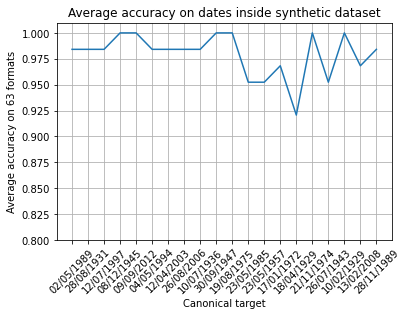

In [0]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([0.8, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates inside synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Below dataset

Dates lower than the synthetic dataset used for test and eval.

In [0]:
accs = []
dates = []

new_dataset = DateTextGenerator('01/01/1900','31/12/1920')


new_df = new_dataset.generate_date_dataset()
sampled_test = random.sample(list(new_df['Target'].values),20)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

acc test set:  ['16/11/1903', '07/04/1900', '24/04/1917', '06/06/1909', '20/07/1904', '13/05/1916', '07/08/1919', '19/03/1901', '09/02/1902', '08/11/1908', '11/01/1912', '22/10/1910', '11/03/1906', '17/05/1911', '19/11/1905', '12/12/1902', '17/08/1909', '01/07/1902', '20/09/1905', '21/01/1920']


Average of average accuracies:  0.44682539682539685


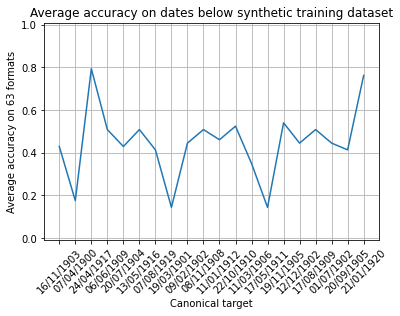

In [0]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates below synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

## Above dataset

Dates greater than the synthetic dataset used for test and eval.

In [0]:
accs = []
dates = []

new_dataset = DateTextGenerator('01/01/2021','31/12/2040')


new_df = new_dataset.generate_date_dataset()
sampled_test = random.sample(list(new_df['Target'].values),20)

print('acc test set: ',sampled_test)

for date_sample in sampled_test:
  accs.append(evaluate_for_a_same_date(date_sample,verbose=False))
  dates.append(date_sample)
  

acc test set:  ['06/07/2039', '19/03/2039', '13/09/2036', '04/04/2037', '27/08/2037', '04/08/2021', '14/05/2036', '05/05/2022', '09/07/2034', '23/04/2036', '19/06/2035', '02/07/2031', '18/09/2022', '15/02/2031', '20/01/2030', '09/01/2022', '04/06/2024', '18/09/2040', '01/12/2031', '02/06/2030']


Average of average accuracies:  0.0


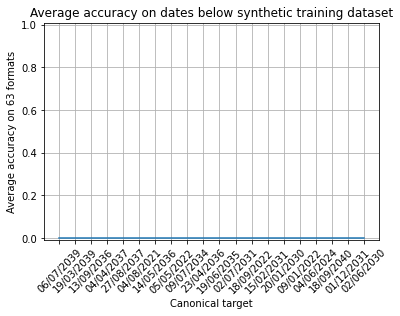

In [0]:
plt.plot(dates,accs)
plt.xticks(rotation=45)
plt.grid()
plt.ylim([-0.01, 1.01])
plt.ylabel('Average accuracy on 63 formats')
plt.xlabel('Canonical target')
plt.title('Average accuracy on dates below synthetic training dataset')
print('Average of average accuracies: ',np.mean(accs))

# The End